<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_02_auto_ml_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML

In [ ]:
COLAB = True

In [46]:
if COLAB:
  !sudo apt-get install git-lfs && git lfs install
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  #!cd dl-projects && ls -l --block-size=M

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'dl-projects'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 739 (delta 66), reused 16 (delta 6), pack-reused 627
Receiving objects: 100% (739/739), 67.30 MiB | 36.27 MiB/s, done.
Resolving deltas: 100% (420/420), done.


In [ ]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [50]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [51]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/"feature_matrix.csv"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/'4D.zip'

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 1151M
-rw------- 1 root root 407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root 428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root 141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 176M Dec 27 08:28 feature_matrix.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan  1 14:47 4D.txt
-rw-r--r-- 1 root root 1M Jan  1 14:47 4D.zip


In [ ]:
data = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['time'])
origin_data = format_tabular(ORIGIN_DATASET)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699972 entries, 0 to 699971
Data columns (total 53 columns):
NumberId                                   699972 non-null int64
time                                       699972 non-null datetime64[ns]
SUM(Results.DrawNo)                        699972 non-null int64
SUM(Results.LuckyNo)                       699972 non-null int64
SUM(Results.TotalStrike)                   699972 non-null int64
STD(Results.DrawNo)                        699575 non-null float64
STD(Results.LuckyNo)                       699575 non-null float64
STD(Results.TotalStrike)                   699575 non-null float64
MAX(Results.DrawNo)                        699972 non-null int64
MAX(Results.LuckyNo)                       699972 non-null int64
MAX(Results.TotalStrike)                   699972 non-null int64
SKEW(Results.DrawNo)                       696365 non-null float64
SKEW(Results.LuckyNo)                      696365 non-null float64
SKEW(Results.TotalStrike)

## Exploratory Data Analysis

In [ ]:
feature_matrix = data

In [56]:
feature_matrix.columns

Index(['NumberId', 'time', 'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'SKEW(Results.DrawNo)',
       'SKEW(Results.LuckyNo)', 'SKEW(Results.TotalStrike)',
       'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
       'MIN(Results.TotalStrike)', 'MEAN(Results.DrawNo)',
       'MEAN(Results.LuckyNo)', 'MEAN(Results.TotalStrike)', 'COUNT(Results)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'YEAR(first_Results_time)', 'MONTH(first_Results_time)',
       'WEEKDAY(first_Results_time)', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Res

In [57]:
feature_matrix.head(4).T

,0,1,2,3
NumberId,0,1,2,3
time,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-01 00:00:00
SUM(Results.DrawNo),1857929,1571202,898913,1628516
SUM(Results.LuckyNo),0,9,8,24
SUM(Results.TotalStrike),8,9,4,8
STD(Results.DrawNo),116257,96697.5,49525.7,116135
STD(Results.LuckyNo),0,0,0,0
STD(Results.TotalStrike),0,0,0,0
MAX(Results.DrawNo),394013,363311,265606,393913
MAX(Results.LuckyNo),0,1,2,3


In [58]:
origin_data[origin_data['LuckyNo']==0].head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
11686,91595,1995-08-02,3rdPrizeNo,0
21541,134398,1998-04-26,SpecialNo1,0
23100,141198,1998-10-01,ConsolationNo5,0
30430,173000,2000-09-09,2ndPrizeNo,0
48346,251005,2005-06-04,1stPrizeNo,0
56190,285107,2007-06-06,2ndPrizeNo,0
79783,387613,2013-05-04,SpecialNo6,0
81258,394013,2013-09-14,SpecialNo9,0
82908,401214,2014-02-08,SpecialNo3,0
85712,413414,2014-10-18,SpecialNo10,0


Text(0, 0.5, 'Strike Per Number')

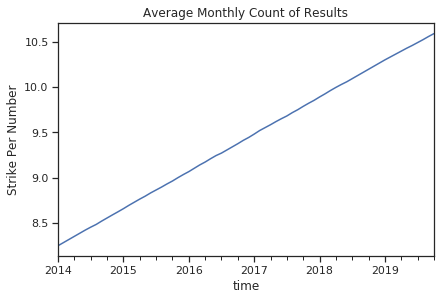

In [59]:
feature_matrix.groupby('time')['COUNT(Results)'].mean().plot()
plt.title('Average Monthly Count of Results')
plt.ylabel('Strike Per Number')

## Feature Selection

In [60]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'NumberId']))

Original shape:  (699972, 51)
0 missing columns with threshold: 90.
7 zero variance columns.
5 collinear columns removed with threshold: 0.95.
Total columns removed:  12
Shape after feature selection: (699972, 39).


In [ ]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['NumberId'] = feature_matrix['NumberId']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [63]:
feature_matrix_selection.columns

Index(['SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
       'SUM(Results.TotalStrike)', 'STD(Results.DrawNo)',
       'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)', 'SKEW(Results.DrawNo)',
       'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)',
       'NUM_UNIQUE(Results.PrizeType)', 'DAY(first_Results_time)',
       'MONTH(first_Results_time)', 'WEEKDAY(first_Results_time)',
       'TotalStrike', 'MODE(Results.PrizeType)_1stPrizeNo',
       'MODE(Results.PrizeType)_2ndPrizeNo',
       'MODE(Results.PrizeType)_3rdPrizeNo',
       'MODE(Results.PrizeType)_ConsolationNo1',
       'MODE(Results.PrizeType)_ConsolationNo10',
       'MODE(Results.PrizeType)_ConsolationNo2',
       'MODE(Results.PrizeType)_ConsolationNo3',
       'MODE(Results.PrizeType)_ConsolationNo4',
       'MODE(Results.PrizeType)_ConsolationNo5',
       'MODE(Results.PrizeType)_ConsolationNo6',
       'MODE(Results.PrizeType)_ConsolationNo7',
       'MODE(Results.PrizeType)_ConsolationNo8',
       'MODE(Results.PrizeType

## Correlations

In [64]:
feature_matrix_selection.shape

(699972, 42)

In [65]:
corrs = feature_matrix_selection.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

MODE(Results.PrizeType)_SpecialNo8       -0.003139
MODE(Results.PrizeType)_ConsolationNo9   -0.002791
year                                     -0.002787
MAX(Results.LuckyNo)                     -0.002340
NumberId                                 -0.002340
Name: TotalStrike, dtype: float64

In [66]:
corrs['Label'].dropna().tail(8)

SUM(Results.TotalStrike)              0.002338
MODE(Results.PrizeType)_SpecialNo9    0.002180
MODE(Results.PrizeType)_SpecialNo6    0.002528
MAX(Results.DrawNo)                   0.003222
MEAN(Results.DrawNo)                  0.003457
SUM(Results.DrawNo)                   0.003557
Label                                 1.000000
TotalStrike                           0.991613
Name: Label, dtype: float64

In [67]:
corrs['TotalStrike'].dropna().tail(8)

SUM(Results.TotalStrike)              0.002227
MODE(Results.PrizeType)_SpecialNo9    0.002269
MODE(Results.PrizeType)_SpecialNo6    0.002818
MAX(Results.DrawNo)                   0.003362
MEAN(Results.DrawNo)                  0.003483
SUM(Results.DrawNo)                   0.003516
Label                                 0.991613
TotalStrike                           1.000000
Name: TotalStrike, dtype: float64

## Visualization

In [ ]:
#pip install autoviz

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class

### CatBoost

In [70]:
!pip install catboost
!pip install ipywidgets

In [ ]:
import catboost as cgb

In [ ]:
model = cgb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)

In [ ]:
def predict_dt(dt, feature_matrix, return_probs = False):

    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    a = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    print(f'Accuracy: {round(a, 5)}')
    print(probs)
    print()
    print(cm)

    m = np.where(predictions==1)
    print(len(m[0]), m)

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [74]:
# All the months
len(feature_matrix_selection['time'].unique()), feature_matrix_selection['time'].unique()

(70, array(['2014-01-01T00:00:00.000000000', '2014-02-01T00:00:00.000000000',
        '2014-03-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
        '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
        '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
        '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
        '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
        '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
        '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
        '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
        '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
        '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
        '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
        '2016-03-01T00:00:00.00000

In [75]:
 %time june_2019 = predict_dt(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 649972
Size of X train 649972
Size of X test  10000
Training on 649972 observations.
Testing on 10000 observations.

0:	total: 344ms	remaining: 2m 51s
1:	total: 670ms	remaining: 2m 46s
2:	total: 995ms	remaining: 2m 44s
3:	total: 1.19s	remaining: 2m 27s
4:	total: 1.52s	remaining: 2m 30s
5:	total: 1.8s	remaining: 2m 28s
6:	total: 2.14s	remaining: 2m 30s
7:	total: 2.46s	remaining: 2m 31s
8:	total: 2.79s	remaining: 2m 32s
9:	total: 3.12s	remaining: 2m 32s
10:	total: 3.45s	remaining: 2m 33s
11:	total: 3.78s	remaining: 2m 33s
12:	total: 4.12s	remaining: 2m 34s
13:	total: 4.45s	remaining: 2m 34s
14:	total: 4.8s	remaining: 2m 35s
15:	total: 5.13s	remaining: 2m 35s
16:	total: 5.47s	remaining: 2m 35s
17:	total: 5.84s	remaining: 2m 36s
18:	total: 6.04s	remaining: 2m 33s
19:	total: 6.37s	remaining: 2m 32s
20:	total: 6.7s	remaining: 2m 32s
21:	total: 7.03s	remaining: 2m 32s
22:	total: 7.36s	remaining: 2m 32s
23:	total: 7.7s	remaining: 2m 32s
24:	total:

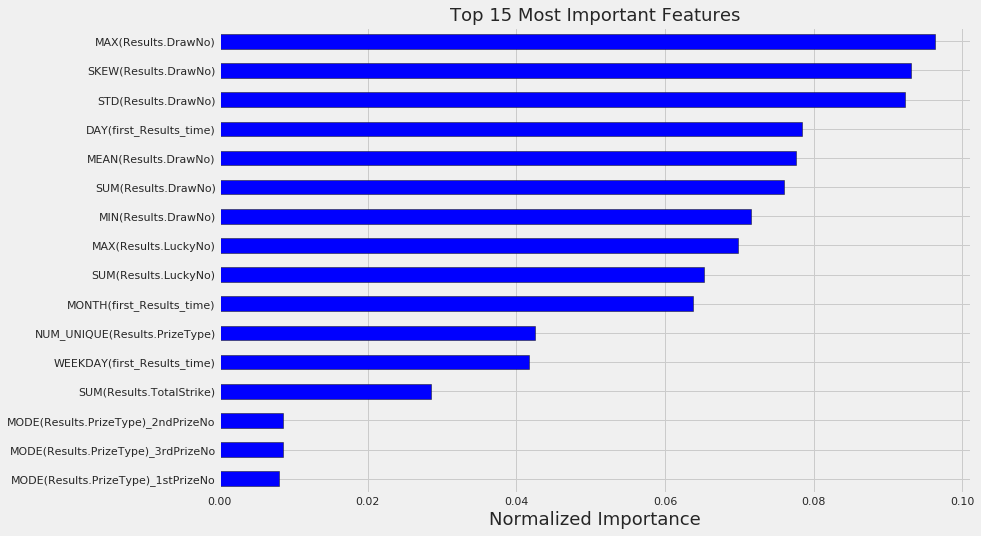

In [76]:
from utils import plot_feature_importances

norm_june_2019_fi = plot_feature_importances(june_2019)

In [77]:
%time july_2019 = predict_dt(pd.datetime(2019,7,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 659972
Size of X train 659972
Size of X test  10000
Training on 659972 observations.
Testing on 10000 observations.

0:	total: 326ms	remaining: 2m 42s
1:	total: 659ms	remaining: 2m 44s
2:	total: 997ms	remaining: 2m 45s
3:	total: 1.22s	remaining: 2m 31s
4:	total: 1.57s	remaining: 2m 35s
5:	total: 1.9s	remaining: 2m 36s
6:	total: 2.23s	remaining: 2m 37s
7:	total: 2.58s	remaining: 2m 38s
8:	total: 2.93s	remaining: 2m 39s
9:	total: 3.26s	remaining: 2m 39s
10:	total: 3.61s	remaining: 2m 40s
11:	total: 3.96s	remaining: 2m 41s
12:	total: 4.29s	remaining: 2m 40s
13:	total: 4.64s	remaining: 2m 41s
14:	total: 4.97s	remaining: 2m 40s
15:	total: 5.3s	remaining: 2m 40s
16:	total: 5.65s	remaining: 2m 40s
17:	total: 6.01s	remaining: 2m 41s
18:	total: 6.35s	remaining: 2m 40s
19:	total: 6.71s	remaining: 2m 40s
20:	total: 7.04s	remaining: 2m 40s
21:	total: 7.37s	remaining: 2m 40s
22:	total: 7.71s	remaining: 2m 39s
23:	total: 8.05s	remaining: 2m 39s
24:	tota

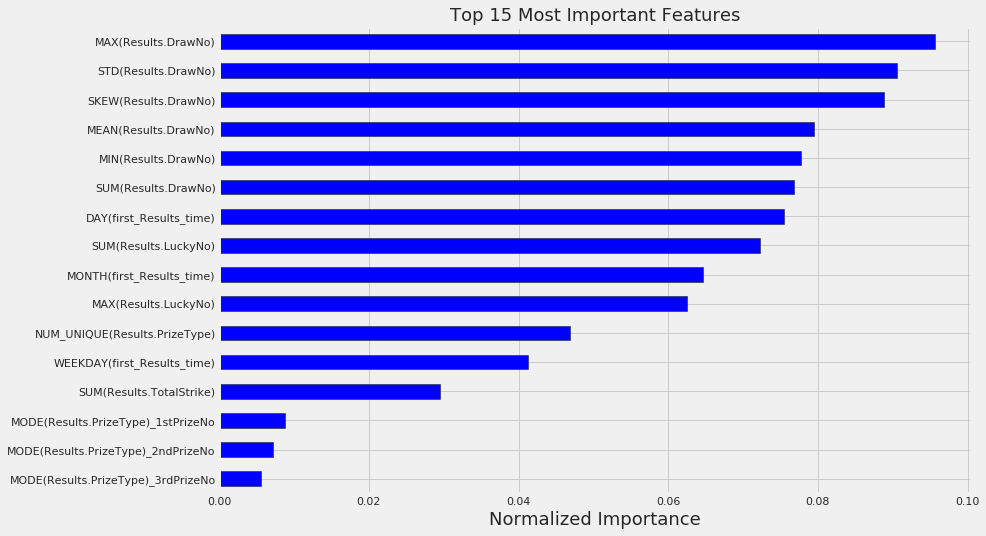

In [78]:
norm_july_2019_fi = plot_feature_importances(july_2019)

### Tuning - GridSearch

## Comparison to Baseline

In [79]:
a = np.array([0,0,0,1,0,1, 1])
print(len(a))
m = np.where(a==1)
print(len(m[0]), a[m[0]])

7
3 [1 1 1]
